In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
n = 200
p = 500
n_informative = 20
n_redundant = 20
n_clusters_per_class = 2
class_weights = [0.6, 0.4]

standardize = True
preprocess_pca = False

In [3]:
def generate_dataset(preprocess_pca=False,
                     pca_n_components=50,
                     random_state=42):
    X, y = make_classification(n_samples=n,
                               n_features=p,
                               n_informative=n_informative,
                               n_redundant=n_redundant,
                               n_clusters_per_class=n_clusters_per_class,
                               weights=class_weights,
                               class_sep=1.75,
                               flip_y=0.0,
                               random_state=random_state)
    if standardize:
        X = StandardScaler().fit_transform(X)
    if preprocess_pca:
        X = PCA(n_components=pca_n_components).fit_transform(X)
    return X, y

X, y = generate_dataset(preprocess_pca)

print(X.shape)
print(X[:5, :5])

(200, 500)
[[-0.6732641   1.44143815  0.65603173 -1.25555873 -0.10252406]
 [-0.30245457  1.54424263  0.12990593  0.07116968 -0.04269515]
 [-0.15725554  1.12867016  0.3026934   0.67613557 -0.60526114]
 [-0.99042465  1.21576172 -0.92570551  0.01008096  0.93380763]
 [-0.01717207 -0.00281123 -0.6395784  -0.95346678  1.77233893]]


In [4]:
print(y.shape)
print(y[:5])

(200,)
[0 0 0 1 0]


In [5]:
def get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test):
    """Given predicted scores and true labels for train and test samples,
    calculate classification metrics.

    y_pred_train and y_pred_test should be continuous (higher = more likely
    to be positively labeled, e.g. output of logistic regression); true values
    are binary.
    """
    train_auroc = roc_auc_score(y_train, y_pred_train, average="weighted")
    test_auroc = roc_auc_score(y_test, y_pred_test, average="weighted")

    train_aupr = average_precision_score(y_train, y_pred_train, average="weighted")
    test_aupr = average_precision_score(y_test, y_pred_test, average="weighted")

    return {
        'train_auroc': train_auroc,
        'test_auroc': test_auroc,
        'train_aupr': train_aupr,
        'test_aupr': test_aupr,
    }

In [6]:
def get_loss(y_train,
             y_pred_train,
             penalty=None,
             weights=None,
             param=None):
    log_likelihood = log_loss(y_train, y_pred_train)
    penalty_fn = 0.0
    if penalty == 'l1':
        penalty_fn = param * np.sum(np.absolute(weights))
    elif penalty == 'l2':
        penalty_fn = (0.5 * param * np.sum(weights ** 2))
    return log_likelihood, penalty_fn

In [7]:
results = []
results_cols = None
seeds = [42, 1]
coefs = {'liblinear': [], 'sgd': []}

# no regularization for now
for seed in seeds:
    
    X, y = generate_dataset(preprocess_pca=preprocess_pca, random_state=seed)
    
    kf = KFold(n_splits=4)
    for fold, (train_ix, test_ix) in enumerate(kf.split(X)):
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        lr = LogisticRegression(random_state=seed).fit(X_train, y_train)
        sgd = SGDClassifier(loss='log_loss', random_state=seed).fit(X_train, y_train)

        y_pred_train_lr = lr.predict(X_train)
        y_pred_test_lr = lr.predict(X_test)
        y_pred_train_sgd = sgd.predict(X_train)
        y_pred_test_sgd = sgd.predict(X_test)

        lr_prob_metrics = get_prob_metrics(y_train, y_test,
                                           y_pred_train_lr, y_pred_test_lr)
        sgd_prob_metrics = get_prob_metrics(y_train, y_test,
                                            y_pred_train_sgd, y_pred_test_sgd)

        if results_cols is None:
            results_cols = list(lr_prob_metrics.keys()) + ['optimizer', 'seed', 'fold']
        else:
            assert results_cols == (list(lr_prob_metrics.keys()) + ['optimizer', 'seed', 'fold'])
        results.append(list(lr_prob_metrics.values()) + ['liblinear', seed, fold])
        results.append(list(sgd_prob_metrics.values()) + ['sgd', seed, fold])
        
        coefs['liblinear'].append([seed, fold, lr.coef_])
        coefs['sgd'].append([seed, fold, sgd.coef_])

    results_df = (
        pd.DataFrame(results, columns=results_cols)
          .melt(id_vars=['optimizer', 'seed', 'fold'], var_name='metric')
    )

print(results_df.shape)
results_df.head()

(64, 5)


,optimizer,seed,fold,metric,value
0,liblinear,42,0,train_auroc,1.0
1,sgd,42,0,train_auroc,1.0
2,liblinear,42,1,train_auroc,1.0
3,sgd,42,1,train_auroc,1.0
4,liblinear,42,2,train_auroc,1.0


In [8]:
# get coefficient vector magnitudes
baseline_coefs_df = []

for optimizer in coefs.keys():
    for [seed, fold, coef] in coefs[optimizer]:
        baseline_coefs_df.append([optimizer, seed, fold, np.sum(np.absolute(coef))])
    
baseline_coefs_df = pd.DataFrame(
    baseline_coefs_df, columns=['optimizer', 'seed', 'fold', 'sum_coefs']
)

print(baseline_coefs_df.shape)
baseline_coefs_df.head()

(16, 4)


,optimizer,seed,fold,sum_coefs
0,liblinear,42,0,41.380400
1,liblinear,42,1,39.427400
2,liblinear,42,2,41.131000
3,liblinear,42,3,40.536790
4,liblinear,1,0,34.905381


<AxesSubplot:xlabel='metric', ylabel='value'>

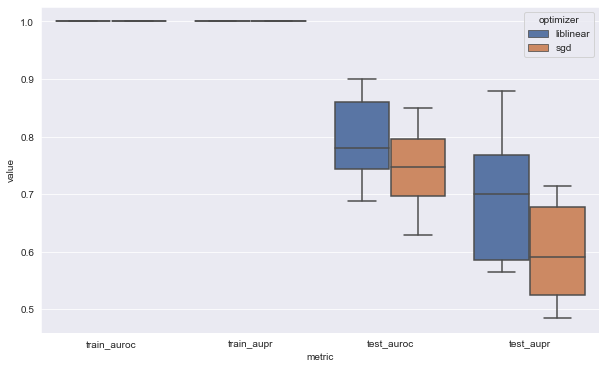

In [9]:
sns.set({'figure.figsize': (10, 6)})

sns.boxplot(data=results_df.sort_values(by='metric', ascending=False),
            x='metric', y='value', hue='optimizer')

In [10]:
results = []
results_cols = None

coefs = {'liblinear': [], 'sgd': []}

losses = []

seeds = [42, 1]
ll_params = np.logspace(-3, 6, 19)
sgd_params = np.logspace(-8, 1, 19)

for seed in seeds:
    
    X, y = generate_dataset(preprocess_pca=preprocess_pca, random_state=seed)
    
    kf = KFold(n_splits=4)

    # L1 regularization
    for fold, (train_ix, test_ix) in enumerate(kf.split(X)):
        print('seed:', seed, 'fold:', fold)
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        for ll_param in ll_params:
            lr = (
                LogisticRegression(penalty='l1',
                                   solver='liblinear',
                                   C=ll_param,
                                   random_state=seed,
                                   max_iter=500)
            ).fit(X_train, y_train)
            y_pred_train_lr = lr.predict(X_train)
            y_pred_test_lr = lr.predict(X_test)
            lr_prob_metrics = get_prob_metrics(y_train, y_test,
                                               y_pred_train_lr, y_pred_test_lr)
            if results_cols is None:
                results_cols = (list(lr_prob_metrics.keys()) +
                                ['optimizer', 'seed', 'fold', 'lasso_param'])
            else:
                assert results_cols == (list(lr_prob_metrics.keys()) +
                                        ['optimizer', 'seed', 'fold', 'lasso_param'])
            results.append(list(lr_prob_metrics.values()) +
                           ['liblinear', seed, fold, ll_param])
            coefs['liblinear'].append([seed, fold, ll_param, lr.coef_])
            
            ll_logl, ll_penalty = get_loss(
                y_train, y_pred_train_lr,
                penalty='l1', weights=lr.coef_, param=(1/ll_param)
            )
            losses.append(['liblinear', seed, fold, ll_param, ll_logl, ll_penalty])
        
        for sgd_param in sgd_params:
            sgd = (
                SGDClassifier(loss='log_loss',
                              penalty='l1',
                              alpha=sgd_param,
                              random_state=seed,
                              # learning_rate='adaptive',
                              # eta0=0.1,
                              max_iter=500)
            ).fit(X_train, y_train)
            y_pred_train_sgd = sgd.predict(X_train)
            y_pred_test_sgd = sgd.predict(X_test)
            sgd_prob_metrics = get_prob_metrics(y_train, y_test,
                                                y_pred_train_sgd, y_pred_test_sgd)
            results.append(list(sgd_prob_metrics.values()) +
                           ['sgd', seed, fold, sgd_param])
            coefs['sgd'].append([seed, fold, sgd_param, sgd.coef_])
            
            sgd_logl, sgd_penalty = get_loss(
                y_train, y_pred_train_sgd,
                penalty='l1', weights=sgd.coef_, param=sgd_param
            )
            losses.append(['sgd', seed, fold, sgd_param, sgd_logl, sgd_penalty])

results_df = (
    pd.DataFrame(results, columns=results_cols)
      .melt(id_vars=['optimizer', 'seed', 'fold', 'lasso_param'], var_name='metric')
)

print(results_df.shape)
results_df.head()

seed: 42 fold: 0
seed: 42 fold: 1
seed: 42 fold: 2
seed: 42 fold: 3
seed: 1 fold: 0
seed: 1 fold: 1
seed: 1 fold: 2
seed: 1 fold: 3
(1216, 6)


,optimizer,seed,fold,lasso_param,metric,value
0,liblinear,42,0,0.001000,train_auroc,0.500000
1,liblinear,42,0,0.003162,train_auroc,0.500000
2,liblinear,42,0,0.010000,train_auroc,0.500000
3,liblinear,42,0,0.031623,train_auroc,0.738889
4,liblinear,42,0,0.100000,train_auroc,0.894444


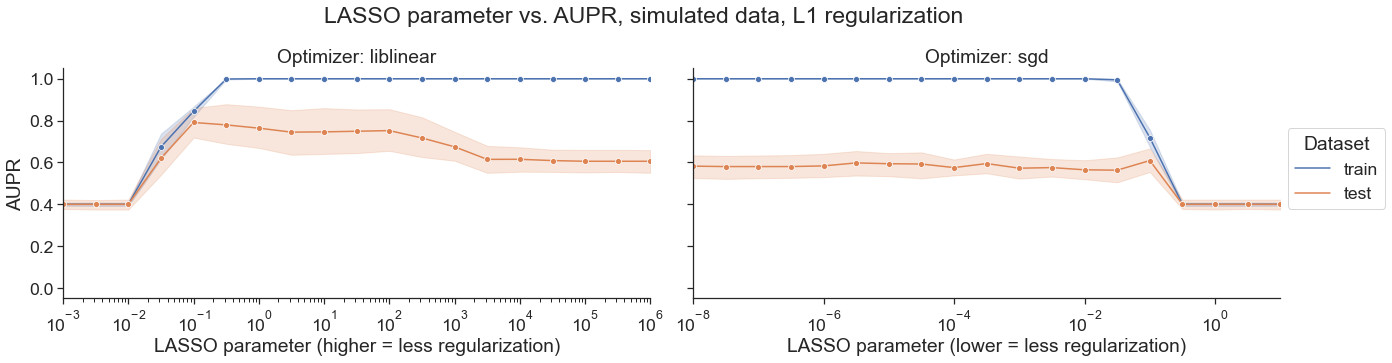

In [11]:
sns.set_style('ticks')

plot_df = results_df[results_df.metric.isin(['train_aupr', 'test_aupr'])]

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y='value', hue='metric',
        hue_order=['train_aupr', 'test_aupr'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log')
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-4, 10e5))
    g.axes[0].set_ylim((-0.05, 1.05))
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-9, 10))
    g.axes[1].set_ylim((-0.05, 1.05))
    g.set_ylabels('AUPR')
    sns.move_legend(g, "center", bbox_to_anchor=[1.035, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. AUPR, simulated data, L1 regularization', y=1.0)

plt.tight_layout()

In [12]:
# get coefficient vector magnitudes
coefs_df = []

for optimizer in coefs.keys():
    for [seed, fold, param, coef] in coefs[optimizer]:
        coefs_df.append([optimizer, seed, fold, param, np.sum(np.absolute(coef))])
    
coefs_df = pd.DataFrame(
    coefs_df, columns=['optimizer', 'seed', 'fold', 'lasso_param', 'sum_coefs']
)

print(coefs_df.shape)
coefs_df.head()

(304, 5)


,optimizer,seed,fold,lasso_param,sum_coefs
0,liblinear,42,0,0.001000,0.000000
1,liblinear,42,0,0.003162,0.000000
2,liblinear,42,0,0.010000,0.000000
3,liblinear,42,0,0.031623,0.148804
4,liblinear,42,0,0.100000,2.519952


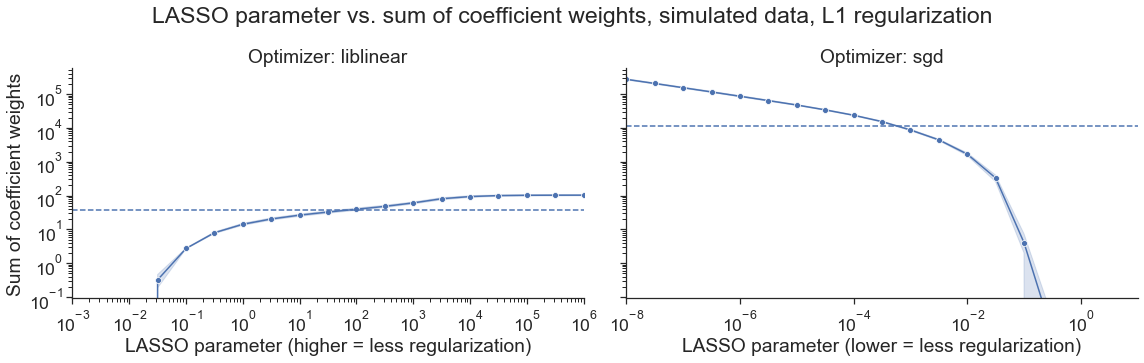

In [13]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=coefs_df,
        x='lasso_param', y='sum_coefs',
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log', yscale='log')
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-4, 10e5))
    g.axes[0].axhline(baseline_coefs_df[baseline_coefs_df.optimizer == 'liblinear'].sum_coefs.mean(), linestyle='--')
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-9, 10))
    g.axes[1].axhline(baseline_coefs_df[baseline_coefs_df.optimizer == 'sgd'].sum_coefs.mean(), linestyle='--')
    g.set_ylabels('Sum of coefficient weights')
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. sum of coefficient weights, simulated data, L1 regularization', y=1.0)

plt.tight_layout()

In [14]:
# get coefficient vector magnitudes
losses_df = pd.DataFrame(
    losses,
    columns=['optimizer', 'seed', 'fold', 'lasso_param',
             'log_likelihood', 'weight_penalty']
)
losses_df['total_loss'] = losses_df.log_likelihood + losses_df.weight_penalty

losses_df = losses_df.melt(
    id_vars=['optimizer', 'seed', 'fold', 'lasso_param'],
    var_name='loss_component', value_name='loss_value'
)

print(losses_df.shape)
losses_df.head()

(912, 6)


,optimizer,seed,fold,lasso_param,loss_component,loss_value
0,liblinear,42,0,0.001000,log_likelihood,13.815511
1,liblinear,42,0,0.003162,log_likelihood,13.815511
2,liblinear,42,0,0.010000,log_likelihood,13.815511
3,liblinear,42,0,0.031623,log_likelihood,9.440753
4,liblinear,42,0,0.100000,log_likelihood,3.914464


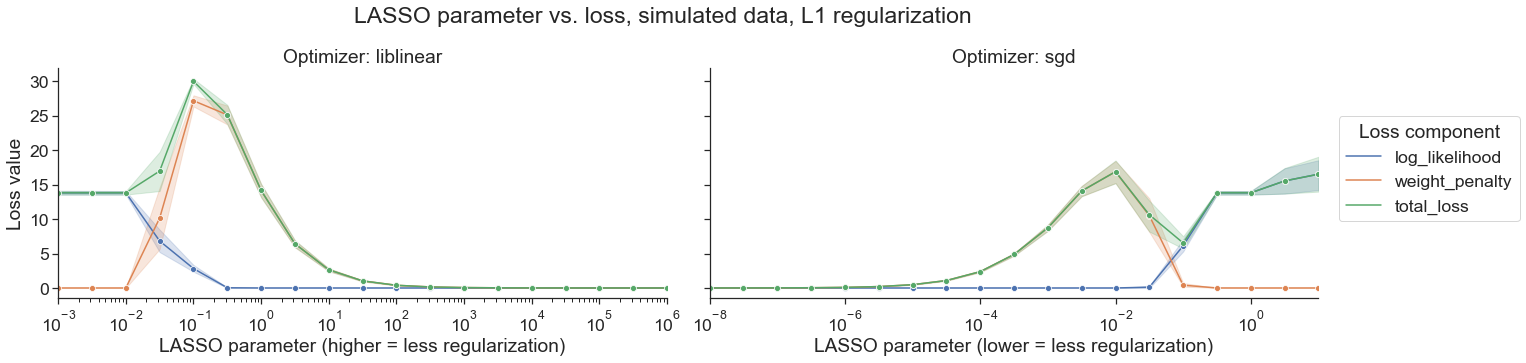

In [15]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=losses_df,
        x='lasso_param', y='loss_value', hue='loss_component',
        hue_order=['log_likelihood', 'weight_penalty', 'total_loss'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log')
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-4, 10e5))
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-9, 10))
    g.set_ylabels('Loss value')
    sns.move_legend(g, "center", bbox_to_anchor=[1.075, 0.55], frameon=True)
    g._legend.set_title('Loss component')
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. loss, simulated data, L1 regularization', y=1.0)

plt.tight_layout()

In [16]:
results = []
results_cols = None

coefs = {'liblinear': [], 'sgd': []}

losses = []

seeds = [42, 1]
ll_params = np.logspace(-5, 6, 23)
sgd_params = np.logspace(-8, 3, 23)

for seed in seeds:
    
    X, y = generate_dataset(preprocess_pca=preprocess_pca, random_state=seed)
    
    kf = KFold(n_splits=4)

    # L2 regularization
    for fold, (train_ix, test_ix) in enumerate(kf.split(X)):
        print('seed:', seed, 'fold:', fold)
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        for ll_param in ll_params:
            lr = (
                LogisticRegression(penalty='l2',
                                   solver='liblinear',
                                   C=ll_param,
                                   random_state=seed,
                                   max_iter=500)
            ).fit(X_train, y_train)
            y_pred_train_lr = lr.predict(X_train)
            y_pred_test_lr = lr.predict(X_test)
            lr_prob_metrics = get_prob_metrics(y_train, y_test,
                                               y_pred_train_lr, y_pred_test_lr)
            if results_cols is None:
                results_cols = (list(lr_prob_metrics.keys()) +
                                ['optimizer', 'seed', 'fold', 'lasso_param'])
            else:
                assert results_cols == (list(lr_prob_metrics.keys()) +
                                        ['optimizer', 'seed', 'fold', 'lasso_param'])
            results.append(list(lr_prob_metrics.values()) +
                           ['liblinear', seed, fold, ll_param])
            coefs['liblinear'].append([seed, fold, ll_param, lr.coef_])
            
            ll_logl, ll_penalty = get_loss(
                y_train, y_pred_train_lr,
                penalty='l2', weights=lr.coef_, param=(1/ll_param)
            )
            losses.append(['liblinear', seed, fold, ll_param, ll_logl, ll_penalty])
        
        for sgd_param in sgd_params:
            sgd = (
                SGDClassifier(loss='log_loss',
                              penalty='l2',
                              alpha=sgd_param,
                              random_state=seed,
                              max_iter=500)
            ).fit(X_train, y_train)
            y_pred_train_sgd = sgd.predict(X_train)
            y_pred_test_sgd = sgd.predict(X_test)
            sgd_prob_metrics = get_prob_metrics(y_train, y_test,
                                                y_pred_train_sgd, y_pred_test_sgd)
            results.append(list(sgd_prob_metrics.values()) +
                           ['sgd', seed, fold, sgd_param])
            coefs['sgd'].append([seed, fold, sgd_param, sgd.coef_])
            
            sgd_logl, sgd_penalty = get_loss(
                y_train, y_pred_train_sgd,
                penalty='l2', weights=sgd.coef_, param=sgd_param
            )
            losses.append(['sgd', seed, fold, sgd_param, sgd_logl, sgd_penalty])

results_df = (
    pd.DataFrame(results, columns=results_cols)
      .melt(id_vars=['optimizer', 'seed', 'fold', 'lasso_param'], var_name='metric')
)

print(results_df.shape)
results_df.head()

seed: 42 fold: 0
seed: 42 fold: 1
seed: 42 fold: 2
seed: 42 fold: 3
seed: 1 fold: 0
seed: 1 fold: 1
seed: 1 fold: 2
seed: 1 fold: 3
(1472, 6)


,optimizer,seed,fold,lasso_param,metric,value
0,liblinear,42,0,0.000010,train_auroc,0.955556
1,liblinear,42,0,0.000032,train_auroc,0.955556
2,liblinear,42,0,0.000100,train_auroc,0.955556
3,liblinear,42,0,0.000316,train_auroc,0.963889
4,liblinear,42,0,0.001000,train_auroc,0.980556


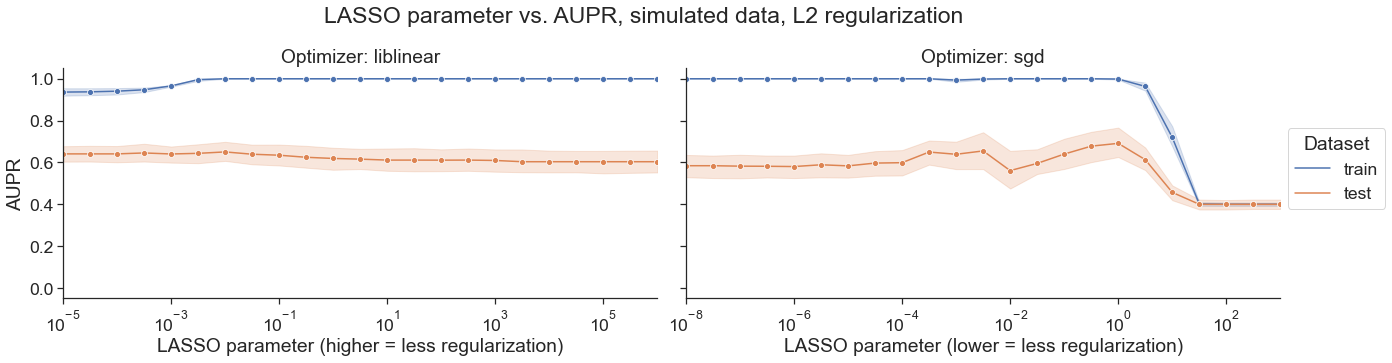

In [17]:
sns.set_style('ticks')

plot_df = results_df[results_df.metric.isin(['train_aupr', 'test_aupr'])]

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y='value', hue='metric',
        hue_order=['train_aupr', 'test_aupr'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log')
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-6, 10e5))
    g.axes[0].set_ylim((-0.05, 1.05))
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-9, 1000))
    g.axes[1].set_ylim((-0.05, 1.05))
    g.set_ylabels('AUPR')
    sns.move_legend(g, "center", bbox_to_anchor=[1.035, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. AUPR, simulated data, L2 regularization', y=1.0)

plt.tight_layout()

In [18]:
# get coefficient vector magnitudes
coefs_df = []

for optimizer in coefs.keys():
    for [seed, fold, param, coef] in coefs[optimizer]:
        coefs_df.append([optimizer, seed, fold, param, np.sum(np.absolute(coef))])
    
coefs_df = pd.DataFrame(
    coefs_df, columns=['optimizer', 'seed', 'fold', 'lasso_param', 'sum_coefs']
)

print(coefs_df.shape)
coefs_df.head()

(368, 5)


,optimizer,seed,fold,lasso_param,sum_coefs
0,liblinear,42,0,0.000010,0.027734
1,liblinear,42,0,0.000032,0.087241
2,liblinear,42,0,0.000100,0.271379
3,liblinear,42,0,0.000316,0.816767
4,liblinear,42,0,0.001000,2.260598


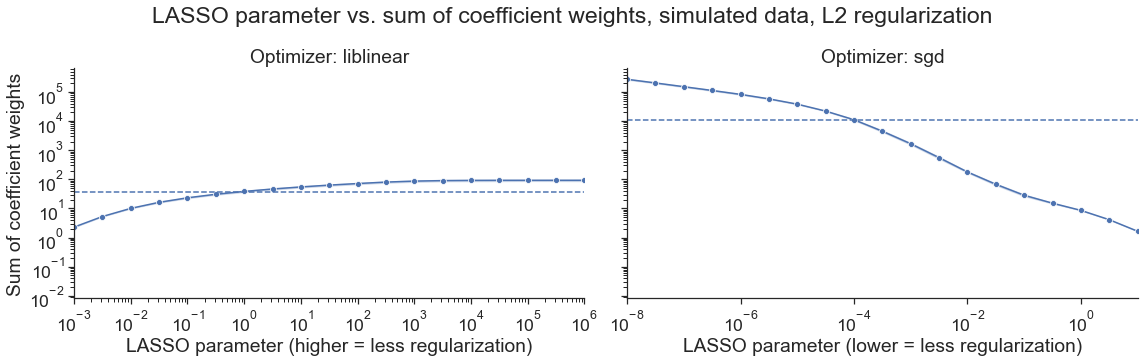

In [19]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=coefs_df,
        x='lasso_param', y='sum_coefs',
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log', yscale='log')
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-4, 10e5))
    g.axes[0].axhline(baseline_coefs_df[baseline_coefs_df.optimizer == 'liblinear'].sum_coefs.mean(), linestyle='--')
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-9, 10))
    g.axes[1].axhline(baseline_coefs_df[baseline_coefs_df.optimizer == 'sgd'].sum_coefs.mean(), linestyle='--')
    g.set_ylabels('Sum of coefficient weights')
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. sum of coefficient weights, simulated data, L2 regularization', y=1.0)

plt.tight_layout()

In [20]:
# get coefficient vector magnitudes
losses_df = pd.DataFrame(
    losses,
    columns=['optimizer', 'seed', 'fold', 'lasso_param',
             'log_likelihood', 'weight_penalty']
)
losses_df['total_loss'] = losses_df.log_likelihood + losses_df.weight_penalty

losses_df = losses_df.melt(
    id_vars=['optimizer', 'seed', 'fold', 'lasso_param'],
    var_name='loss_component', value_name='loss_value'
)

print(losses_df.shape)
losses_df.head()

(1104, 6)


,optimizer,seed,fold,lasso_param,loss_component,loss_value
0,liblinear,42,0,0.000010,log_likelihood,1.381562
1,liblinear,42,0,0.000032,log_likelihood,1.381562
2,liblinear,42,0,0.000100,log_likelihood,1.381562
3,liblinear,42,0,0.000316,log_likelihood,1.151303
4,liblinear,42,0,0.001000,log_likelihood,0.690786


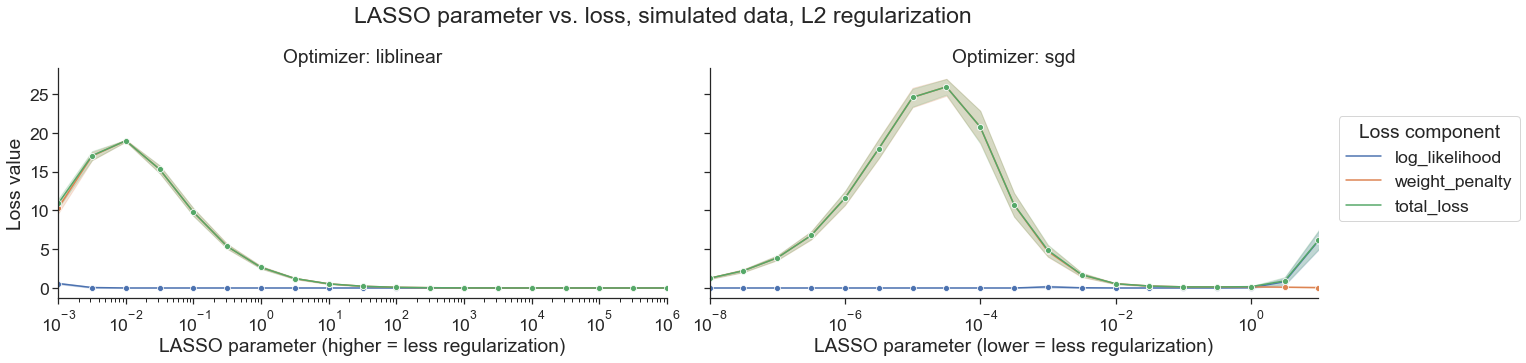

In [21]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=losses_df,
        x='lasso_param', y='loss_value', hue='loss_component',
        hue_order=['log_likelihood', 'weight_penalty', 'total_loss'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log')
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-4, 10e5))
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-9, 10))
    g.set_ylabels('Loss value')
    sns.move_legend(g, "center", bbox_to_anchor=[1.075, 0.55], frameon=True)
    g._legend.set_title('Loss component')
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. loss, simulated data, L2 regularization', y=1.0)

plt.tight_layout()